In [31]:
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, KernelPCA
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier
import random

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) # display all columns

In [2]:
data = pd.read_csv('./input/data.csv')

data.set_index('shot_id', inplace=True)
data["action_type"] = data["action_type"].astype('object')
data["combined_shot_type"] = data["combined_shot_type"].astype('category')
data["game_event_id"] = data["game_event_id"].astype('category')
data["game_id"] = data["game_id"].astype('category')
data["period"] = data["period"].astype('object')
data["playoffs"] = data["playoffs"].astype('category')
data["season"] = data["season"].astype('category')
data["shot_made_flag"] = data["shot_made_flag"].astype('category')
data["shot_type"] = data["shot_type"].astype('category')
data["team_id"] = data["team_id"].astype('category')

In [3]:
data.head(5)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
2,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
3,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
4,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
5,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR


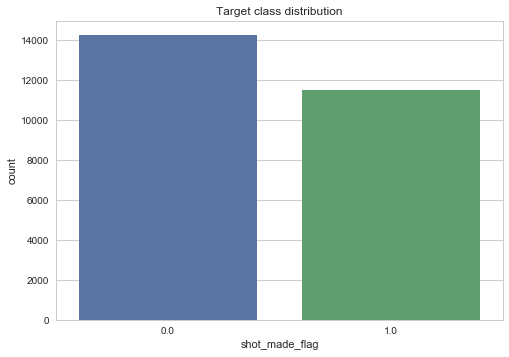

In [4]:
ax = plt.axes()
sns.countplot(x='shot_made_flag', data=data, ax=ax);
ax.set_title('Target class distribution')
plt.show()

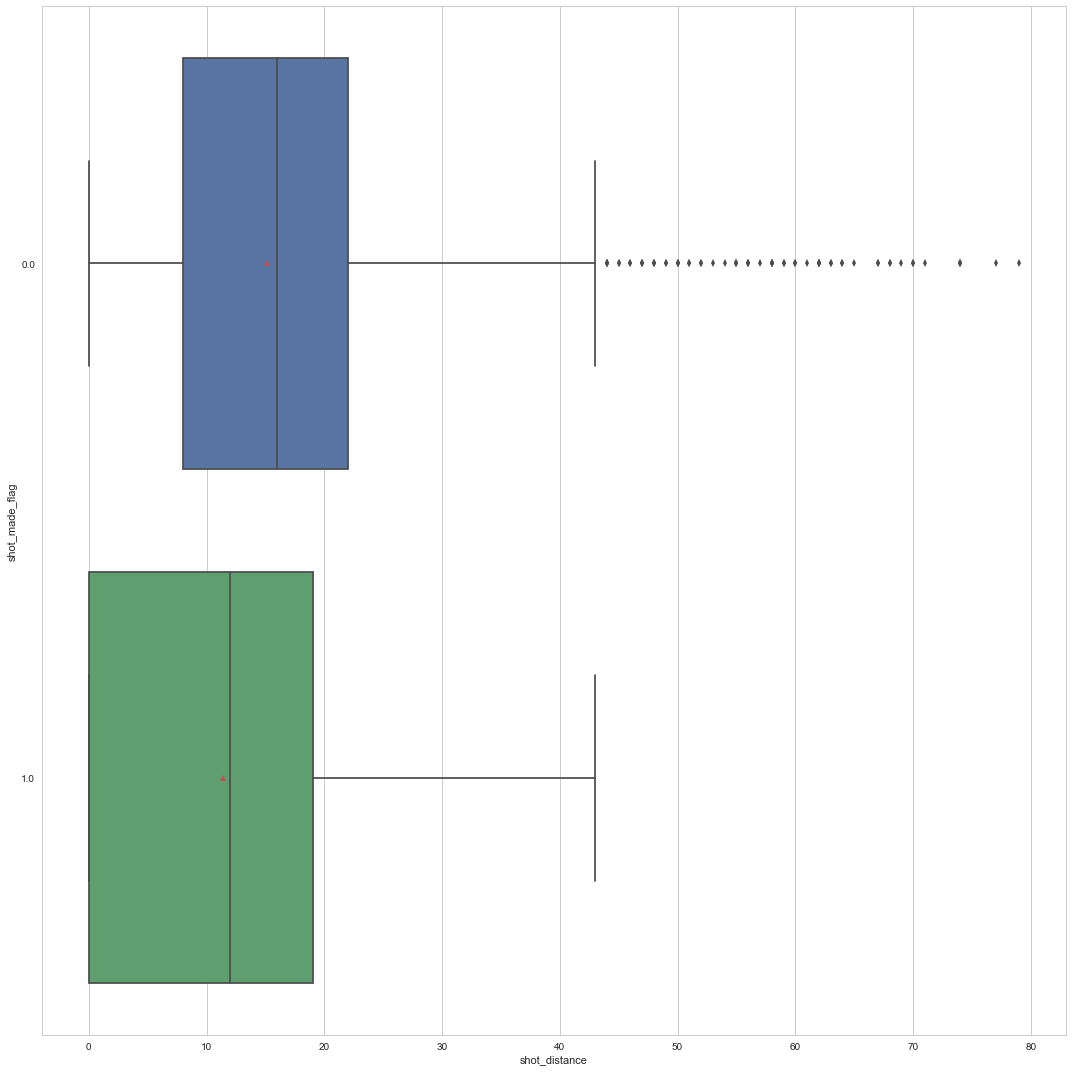

In [68]:
f, axarr = plt.subplots(1, 1, figsize=(15, 15))

sns.boxplot(x='shot_distance', y='shot_made_flag', data=data, showmeans=True)


plt.tight_layout()
plt.show()

In [52]:
miss = 0
count = 0
for entry in data["shot_made_flag"]:
    if entry == 0.0:
        count = count + 1
        miss = miss + 1
    if entry == 1.0:
        count = count + 1
        
print("Mr. Bryant misses about", miss/count*100, "percent of his shots!")

Mr. Bryant misses about 55.38389695295171 percent of his shots!


In [6]:
unknown_mask = data['shot_made_flag'].isnull()

In [7]:
unknown_mask[:5]

shot_id
1     True
2    False
3    False
4    False
5    False
Name: shot_made_flag, dtype: bool

In [8]:
data_cl = data.copy() # create a copy of data frame
target = data_cl['shot_made_flag'].copy()

# Remove some columns
data_cl.drop('team_id', axis=1, inplace=True) # Always one number
data_cl.drop('lat', axis=1, inplace=True) # Correlated with loc_x
data_cl.drop('lon', axis=1, inplace=True) # Correlated with loc_y
data_cl.drop('game_id', axis=1, inplace=True) # Independent
data_cl.drop('game_event_id', axis=1, inplace=True) # Independent
data_cl.drop('team_name', axis=1, inplace=True) # Always LA Lakers
data_cl.drop('shot_made_flag', axis=1, inplace=True) # Already separated for targets
data_cl.drop('game_date', axis=1, inplace=True) # Time isn't taken into consideration

In [9]:
data_cl.head(2)

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent
shot_id,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,167,72,10,1,0,2000-01,27,18,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,LAL @ POR,POR
2,Jump Shot,Jump Shot,-157,0,10,1,0,2000-01,22,15,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,LAL @ POR,POR


In [10]:
# Loc_x, and loc_y binning
data_cl['loc_x'] = pd.cut(data_cl['loc_x'], 25)
data_cl['loc_y'] = pd.cut(data_cl['loc_y'], 25)

# Matchup - (away/home)
data_cl['home_play'] = data_cl['matchup'].str.contains('vs').astype('int')
data_cl.drop('matchup', axis=1, inplace=True)

# Replace 20 least common action types with value 'Other'
rare_action_types = data_cl['action_type'].value_counts().sort_values().index.values[:20]
data_cl.loc[data_cl['action_type'].isin(rare_action_types), 'action_type'] = 'Other'

In [11]:
data_cl.head(2)

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,home_play
shot_id,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,"(148.4, 168.32]","(56.2, 89.6]",10,1,0,2000-01,27,18,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,POR,0
2,Jump Shot,Jump Shot,"(-170.32, -150.4]","(-10.6, 22.8]",10,1,0,2000-01,22,15,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,POR,0


In [12]:
data_cl.columns.tolist()

['action_type',
 'combined_shot_type',
 'loc_x',
 'loc_y',
 'minutes_remaining',
 'period',
 'playoffs',
 'season',
 'seconds_remaining',
 'shot_distance',
 'shot_type',
 'shot_zone_area',
 'shot_zone_basic',
 'shot_zone_range',
 'opponent',
 'home_play']

In [13]:
categorial_cols = [
    'action_type', 'combined_shot_type', 'period', 'season', 'shot_type',
    'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'opponent', 'loc_x', 'loc_y']

for cc in categorial_cols:
    dummies = pd.get_dummies(data_cl[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    data_cl.drop(cc, axis=1, inplace=True)
    data_cl = data_cl.join(dummies)

In [14]:
# Separate dataset for validation
data_submit = data_cl[unknown_mask]

# Separate dataset for training
X = data_cl[~unknown_mask]
Y = target[~unknown_mask]

In [15]:
X.head(2)

,minutes_remaining,playoffs,seconds_remaining,shot_distance,home_play,action_type#Alley Oop Dunk Shot,action_type#Alley Oop Layup shot,action_type#Driving Dunk Shot,action_type#Driving Finger Roll Layup Shot,action_type#Driving Finger Roll Shot,action_type#Driving Jump shot,action_type#Driving Layup Shot,action_type#Driving Reverse Layup Shot,action_type#Driving Slam Dunk Shot,action_type#Dunk Shot,action_type#Fadeaway Bank shot,action_type#Fadeaway Jump Shot,action_type#Finger Roll Layup Shot,action_type#Finger Roll Shot,action_type#Floating Jump shot,action_type#Follow Up Dunk Shot,action_type#Hook Shot,action_type#Jump Bank Shot,action_type#Jump Hook Shot,action_type#Jump Shot,action_type#Layup Shot,action_type#Other,action_type#Pullup Jump shot,action_type#Putback Layup Shot,action_type#Reverse Dunk Shot,action_type#Reverse Layup Shot,action_type#Reverse Slam Dunk Shot,action_type#Running Bank shot,action_type#Running Dunk Shot,action_type#Running Hook Shot,action_type#Running Jump Shot,action_type#Running Layup Shot,action_type#Slam Dunk Shot,action_type#Step Back Jump shot,action_type#Tip Shot,action_type#Turnaround Bank shot,action_type#Turnaround Fadeaway shot,action_type#Turnaround Jump Shot,combined_shot_type#Bank Shot,combined_shot_type#Dunk,combined_shot_type#Hook Shot,combined_shot_type#Jump Shot,combined_shot_type#Layup,combined_shot_type#Tip Shot,period#1,period#2,period#3,period#4,period#5,period#6,period#7,season#1996-97,season#1997-98,season#1998-99,season#1999-00,season#2000-01,season#2001-02,season#2002-03,season#2003-04,season#2004-05,season#2005-06,season#2006-07,season#2007-08,season#2008-09,season#2009-10,season#2010-11,season#2011-12,season#2012-13,season#2013-14,season#2014-15,season#2015-16,shot_type#2PT Field Goal,shot_type#3PT Field Goal,shot_zone_area#Back Court(BC),shot_zone_area#Center(C),shot_zone_area#Left Side Center(LC),shot_zone_area#Left Side(L),shot_zone_area#Right Side Center(RC),shot_zone_area#Right Side(R),shot_zone_basic#Above the Break 3,shot_zone_basic#Backcourt,shot_zone_basic#In The Paint (Non-RA),shot_zone_basic#Left Corner 3,shot_zone_basic#Mid-Range,shot_zone_basic#Restricted Area,shot_zone_basic#Right Corner 3,shot_zone_range#16-24 ft.,shot_zone_range#24+ ft.,shot_zone_range#8-16 ft.,shot_zone_range#Back Court Shot,shot_zone_range#Less Than 8 ft.,opponent#ATL,opponent#BKN,opponent#BOS,opponent#CHA,opponent#CHI,opponent#CLE,opponent#DAL,opponent#DEN,opponent#DET,opponent#GSW,opponent#HOU,opponent#IND,opponent#LAC,opponent#MEM,opponent#MIA,opponent#MIL,opponent#MIN,opponent#NJN,opponent#NOH,opponent#NOP,opponent#NYK,opponent#OKC,opponent#ORL,opponent#PHI,opponent#PHX,opponent#POR,opponent#SAC,opponent#SAS,opponent#SEA,opponent#TOR,opponent#UTA,opponent#VAN,opponent#WAS,"loc_x#(-250.498, -230.08]","loc_x#(-230.08, -210.16]","loc_x#(-210.16, -190.24]","loc_x#(-190.24, -170.32]","loc_x#(-170.32, -150.4]","loc_x#(-150.4, -130.48]","loc_x#(-130.48, -110.56]","loc_x#(-110.56, -90.64]","loc_x#(-90.64, -70.72]","loc_x#(-70.72, -50.8]","loc_x#(-50.8, -30.88]","loc_x#(-30.88, -10.96]","loc_x#(-10.96, 8.96]","loc_x#(8.96, 28.88]","loc_x#(28.88, 48.8]","loc_x#(48.8, 68.72]","loc_x#(68.72, 88.64]","loc_x#(88.64, 108.56]","loc_x#(108.56, 128.48]","loc_x#(128.48, 148.4]","loc_x#(148.4, 168.32]","loc_x#(168.32, 188.24]","loc_x#(188.24, 208.16]","loc_x#(208.16, 228.08]","loc_x#(228.08, 248.0]","loc_y#(-44.835, -10.6]","loc_y#(-10.6, 22.8]","loc_y#(22.8, 56.2]","loc_y#(56.2, 89.6]","loc_y#(89.6, 123.0]","loc_y#(123.0, 156.4]","loc_y#(156.4, 189.8]","loc_y#(189.8, 223.2]","loc_y#(223.2, 256.6]","loc_y#(256.6, 290.0]","loc_y#(290.0, 323.4]","loc_y#(323.4, 356.8]","loc_y#(356.8, 390.2]","loc_y#(390.2, 423.6]","loc_y#(423.6, 457.0]","loc_y#(457.0, 490.4]","loc_y#(490.4, 523.8]","loc_y#(523.8, 557.2]","loc_y#(557.2, 590.6]","loc_y#(590.6, 624.0]","loc_y#(624.0, 657.4]","loc_y#(657.4, 690.8]","loc_y#(690.8, 724.2]","loc_y#(724.2, 757.6]","loc_y#(757.6, 791.0]"
shot_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [16]:
Y.head(2)

shot_id
2    0.0
3    1.0
Name: shot_made_flag, dtype: category
Categories (2, float64): [0.0, 1.0]

In [17]:
model = RandomForestClassifier()
model.fit(X, Y)

feature_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["importance"])
features = feature_imp.sort_values("importance", ascending=False).head(7).index

In [18]:
features

Index(['seconds_remaining', 'minutes_remaining', 'shot_distance',
       'action_type#Jump Shot', 'home_play', 'period#3', 'playoffs'],
      dtype='object')

In [19]:
data_cl = data_cl.ix[:, features]
data_submit = data_submit.ix[:, features]
X = X.ix[:, features]

In [20]:
seed = 7
processors=1
num_folds=3
num_instances=len(X)
scoring='log_loss'

kfold = KFold(n=num_instances, n_folds=num_folds, random_state=seed)

In [21]:
# Prepare some basic models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('K-NN', KNeighborsClassifier(n_neighbors=5)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

# Evaluate each model in turn
results = []
names = []

for name, model in models:
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=processors)
    results.append(cv_results)
    names.append(name)
    print("{0}: ({1:.3f}) +/- ({2:.3f})".format(name, cv_results.mean(), cv_results.std()))

/Users/Simran/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Simran/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Simran/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Simran/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Simran/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127

LR: (-0.641) +/- (0.002)
LDA: (-0.641) +/- (0.002)


/Users/Simran/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Simran/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Simran/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Simran/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Simran/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127

K-NN: (-1.981) +/- (0.041)
CART: (-14.081) +/- (0.040)
NB: (-0.668) +/- (0.007)


/Users/Simran/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Simran/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Simran/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Simran/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


In [22]:
def get_results(targets, predictions):
    correct = 0
    for index in range(len(predictions)):
        target = targets[index]
        prediction = predictions[index]
        if (target - prediction) == 0:
            correct = correct + 1
    return correct/len(predictions)

In [23]:
len(X)

25697

In [24]:
pres_train_x = X[:18000]
pres_train_y = Y[:18000]

In [25]:
pres_x = X[:18001]
pres_y = Y[:18001]

In [47]:
random.seed(1)
# Evaluate each model in turn
results = []
names = []

for name, model in models:
    print(model)
    cv_results = model.fit(pres_train_x, pres_train_y).predict(pres_x)
    results.append(get_results(np.array(pres_y), cv_results))
    names.append(name)
    print("{0}: ({1:.3f}) +/- ({2:.3f})".format(name, cv_results.mean(), cv_results.std()))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
LR: (0.389) +/- (0.488)
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
LDA: (0.389) +/- (0.488)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
K-NN: (0.406) +/- (0.491)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
CART: (0.410) +/- (0.492)
GaussianNB(priors=N

In [48]:
print(results)

[0.6589633909227265, 0.6589633909227265, 0.72257096827954, 0.9351702683184268, 0.6592411532692628]


In [49]:
pres_model = models[3][1].fit(pres_train_x, pres_train_y)

In [50]:
pres_results = pres_model.predict(pres_x)

In [51]:
get_results(np.array(pres_y), pres_results)

0.9351702683184268